In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import random
from scipy.stats import norm

In [2]:
from utils import *
from param_init import *
from exact_sol import *
from evaluation import *
from batching import *
from Adaptive_sampling import *
from Probability_algorithm import *


set_seed()

### Importing or making the PINN

In [3]:
specs = {
        't': {'range': 5.0},
       'm':  {'mean': 1.0,  'std': 0.1, 'lower_multiplier': -2, 'upper_multiplier': 8},
       'mu': {'mean': 0.6,  'std': 0.05, 'lower_multiplier': -8, 'upper_multiplier': 2},
       'k':  {'mean': 5.0,  'std': 0.5, 'lower_multiplier': -5, 'upper_multiplier': 5},
       'y0': {'mean': -0.4, 'std': 0.1, 'lower_multiplier': -5, 'upper_multiplier': 5},
       'v0': {'mean': 3.0,  'std': 0.5, 'lower_multiplier': -5, 'upper_multiplier': 5},
    }

# Run training pipeline
params=initialize_param(500,distribute=['m','mu'],specs=specs, normalize=True)
#,'k','y0','v0'

# I only normalize the input parameters that are diustributed. That means that if training on all params, it expects 0 for mean. But if I change distribute to only 
# some params, I need to change the mean of the other params to 0 for it to be correct. 

In [4]:
vanilla_model = PINN_vanilla_oscillator(hidden_size=20, hidden_layers=3)

P2INN_model = P2INN_oscillator(
                 param_hidden= 10,
                 param_layers= 4,
                 coord_hidden= 10,
                 coord_layers = 3,
                 decoder_hidden = 20,
                 decoder_layers = 6)

if os.path.exists("loss_history.npy"):
    os.remove("loss_history.npy")

Epoch 0, PDE loss: 0.6783046722412109, BC loss: 9.302628517150879


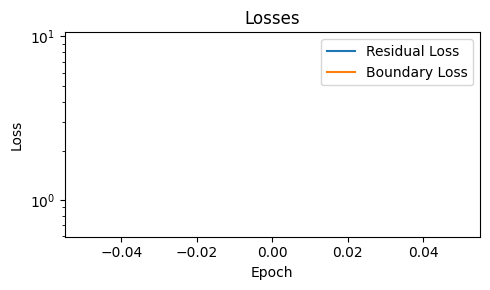

Epoch 1000, PDE loss: 0.12420821934938431, BC loss: 0.00560739915817976


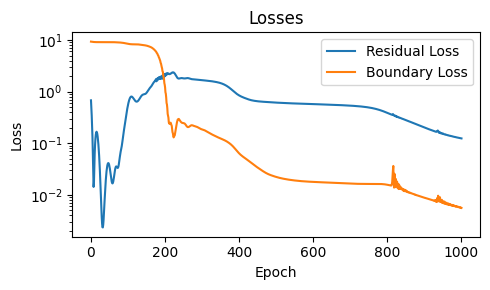

Epoch 2000, PDE loss: 0.028631389141082764, BC loss: 0.0008643046603538096


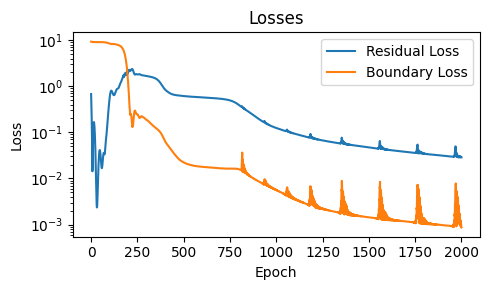

Epoch 3000, PDE loss: 0.010876932181417942, BC loss: 0.00028179469518363476


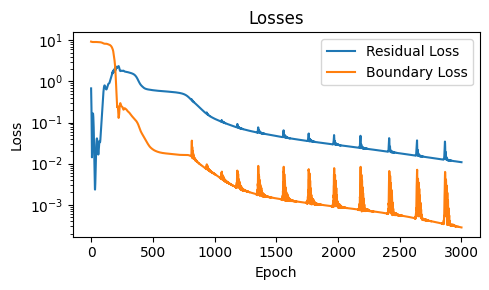

Epoch 4000, PDE loss: 0.0049407389014959335, BC loss: 0.00011942075070692226


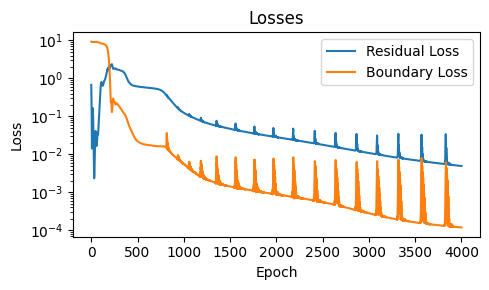

Phase 1 complete. Best loss so far: 0.0051795803010463715
Improved loss found: 0.005176245234906673 (after 1 extra epochs)


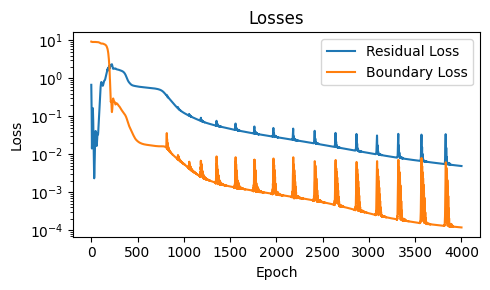

In [5]:
optimizer = optim.Adam(vanilla_model.parameters(), lr=0.001)
trainer = Trainer(vanilla_model, optimizer,epochs=4001, lambda_bc=2.0)
trainer.train(params)

In [12]:
import os

# Save the model's state dictionary to the "Trained models" folder
model_path = "Trained models/m_mu_500_norm_4001_vanilla.pth"

if os.path.exists(model_path):
    response = input(f"The file '{model_path}' already exists. Do you want to replace it? (yes/no): ").strip().lower()
    if response != 'yes':
        print("Model saving aborted.")
    else:
        torch.save(vanilla_model.state_dict(), model_path)
        print(f"Model's state dictionary saved to {model_path}")
else:
    torch.save(vanilla_model.state_dict(), model_path)
    print(f"Model's state dictionary saved to {model_path}")

Model's state dictionary saved to Trained models/m_mu_500_norm_4001_vanilla.pth


In [ ]:
# P2INN_model = P2INN_oscillator(10, 4, 10, 3, 20, 6)
# # Load the saved state dictionary with weights_only=True
# P2INN_model.load_state_dict(torch.load("Trained models/" \
# "m_mu_500_norm_4001.pth"
# , weights_only=True))
# P2INN_model.eval()

In [6]:
PINN_model = PINN_vanilla_oscillator()
# Load the saved state dictionary with weights_only=True
PINN_model.load_state_dict(torch.load("Trained models/" \
"m_mu_500_norm_4001_vanilla.pth"
, weights_only=True))
PINN_model.eval()

PINN_vanilla_oscillator(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [7]:
m_mean, m_std = specs['m']['mean'], specs['m']['std']
mu_mean, mu_std = specs['mu']['mean'], specs['mu']['std']
k_mean, k_std = specs['k']['mean'], specs['k']['std']
y0_mean, y0_std = specs['y0']['mean'], specs['y0']['std']
v0_mean, v0_std = specs['v0']['mean'], specs['v0']['std']

N=100
t_coll = torch.linspace(0, 5, N).view(-1, 1) / specs['t']['range']
t_test = np.linspace(0, 5, N)

### Evaluating model performance

In [8]:
print(params.keys())
print(params['norm_info'])

dict_keys(['t_coll', 'norm_info', 'm', 'mu', 'k', 'y0', 'v0', 't0'])
{'t': {'range': 5.0}, 'm': {'mean': 1.0, 'std': 0.1}, 'mu': {'mean': 0.6, 'std': 0.05}}


<!-- m, mu, k, y0 not norm
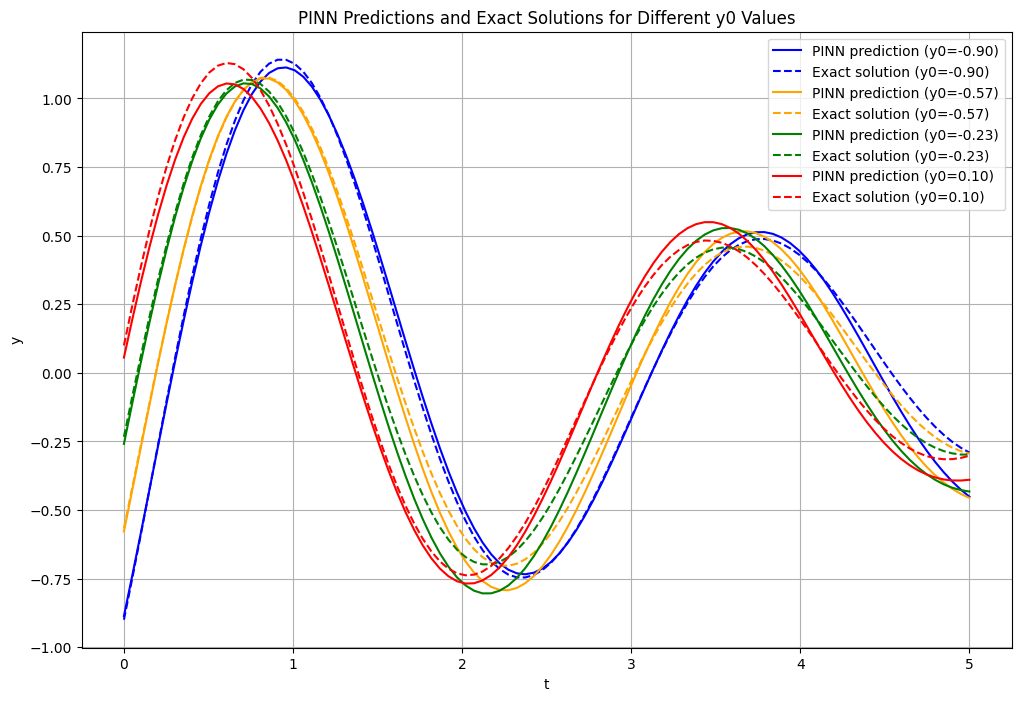


m_mu_y0_500_norm_4001
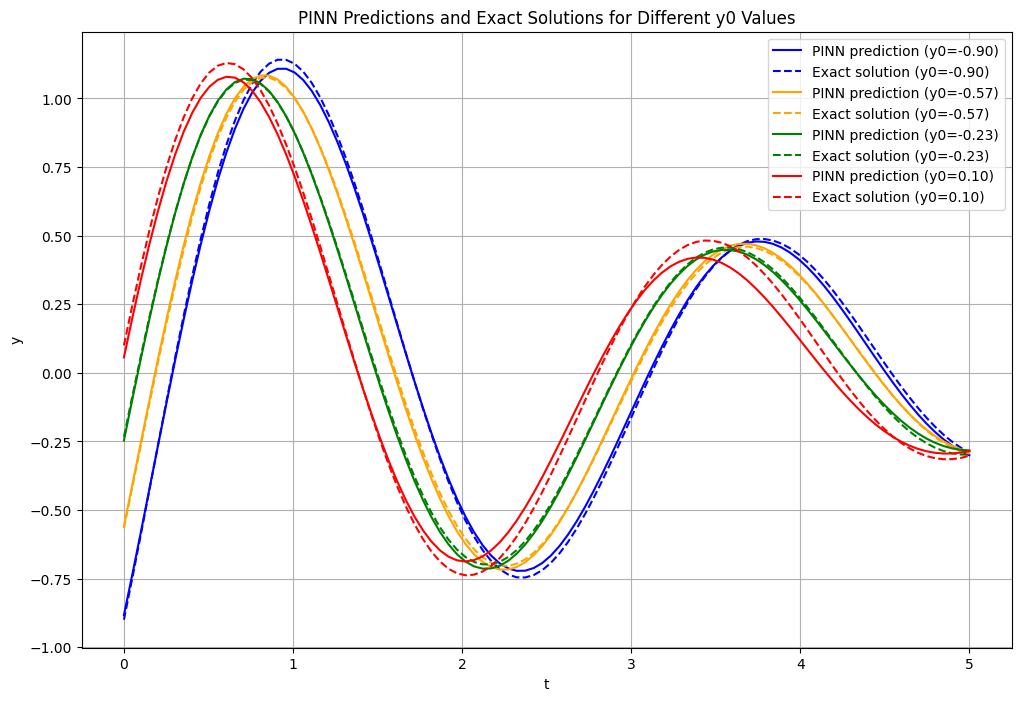 -->

<!-- m_mu_k_y0_500_norm_4001
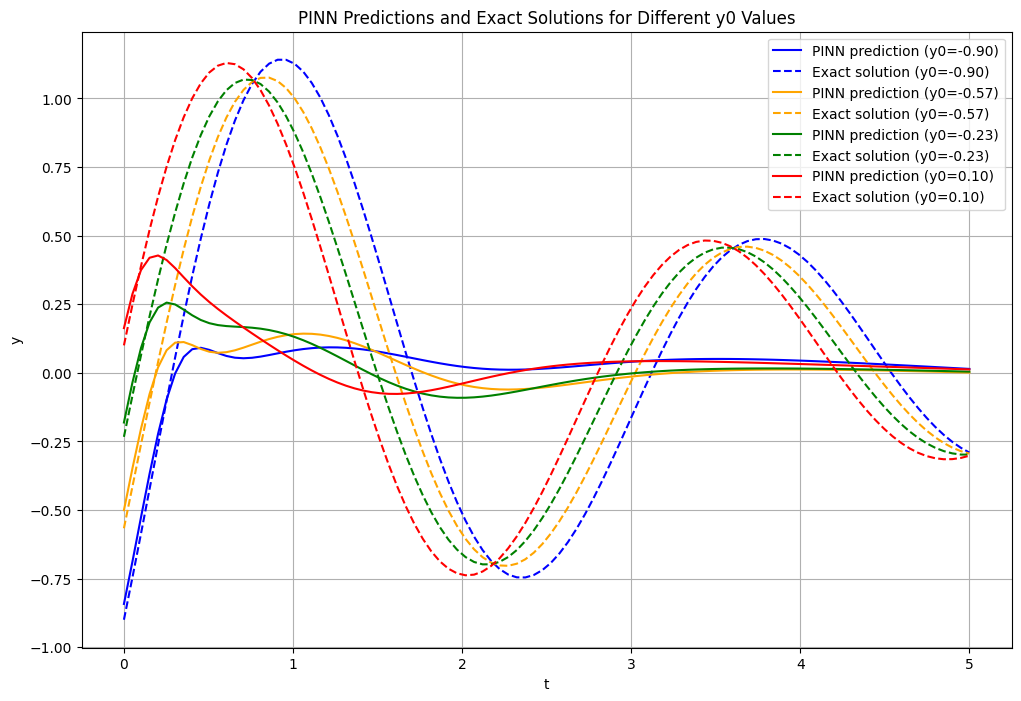

m_mu_k_y0_500_norm_notT_4001
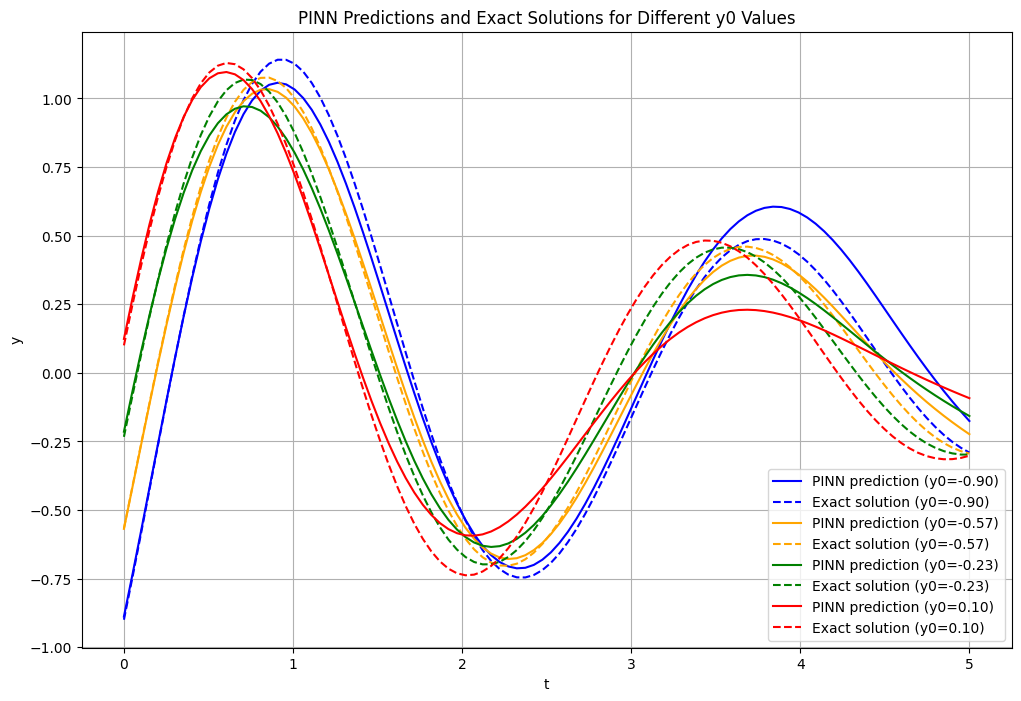

m_mu_k_y0_v0_500_norm_notT_4001
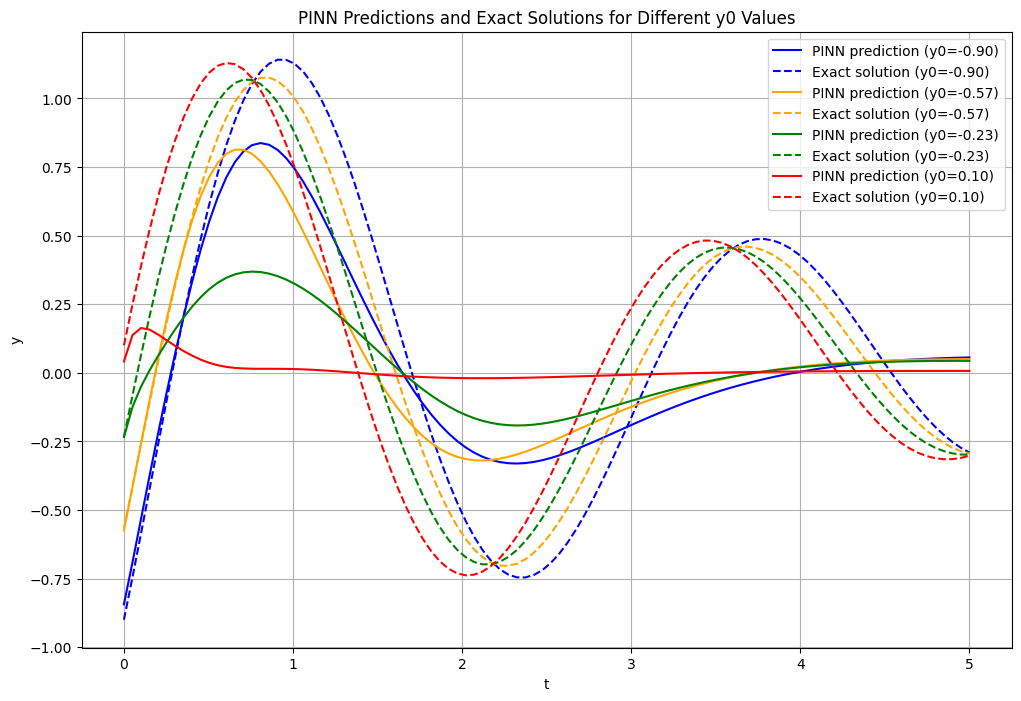 -->

In [9]:
combined_mse=combo_evaluation(PINN_model, specs, params['norm_info'], Num_times=100)
print(f"\nCombined Mean Squared Error over all combinations: {combined_mse:.6f}")

Number of combinations: 36

Combined Mean Squared Error over all combinations: 0.003413


**all:**

all_5000_norm_4001_P2INN_10_4_10_3_20_6 : 0.010207

all_5000_norm_4001_P2INN_10_4_10_3_20_6: 0.001530

all_5000_norm_4001_vanilla: 0.001966  ## WHAT? 

all_5000_norm_4001_vanilla_newstds: 0.011611

**m_mu:**

m_mu_500_norm_4001: 0.003413 

m_mu_500_norm_8001: 0.000672



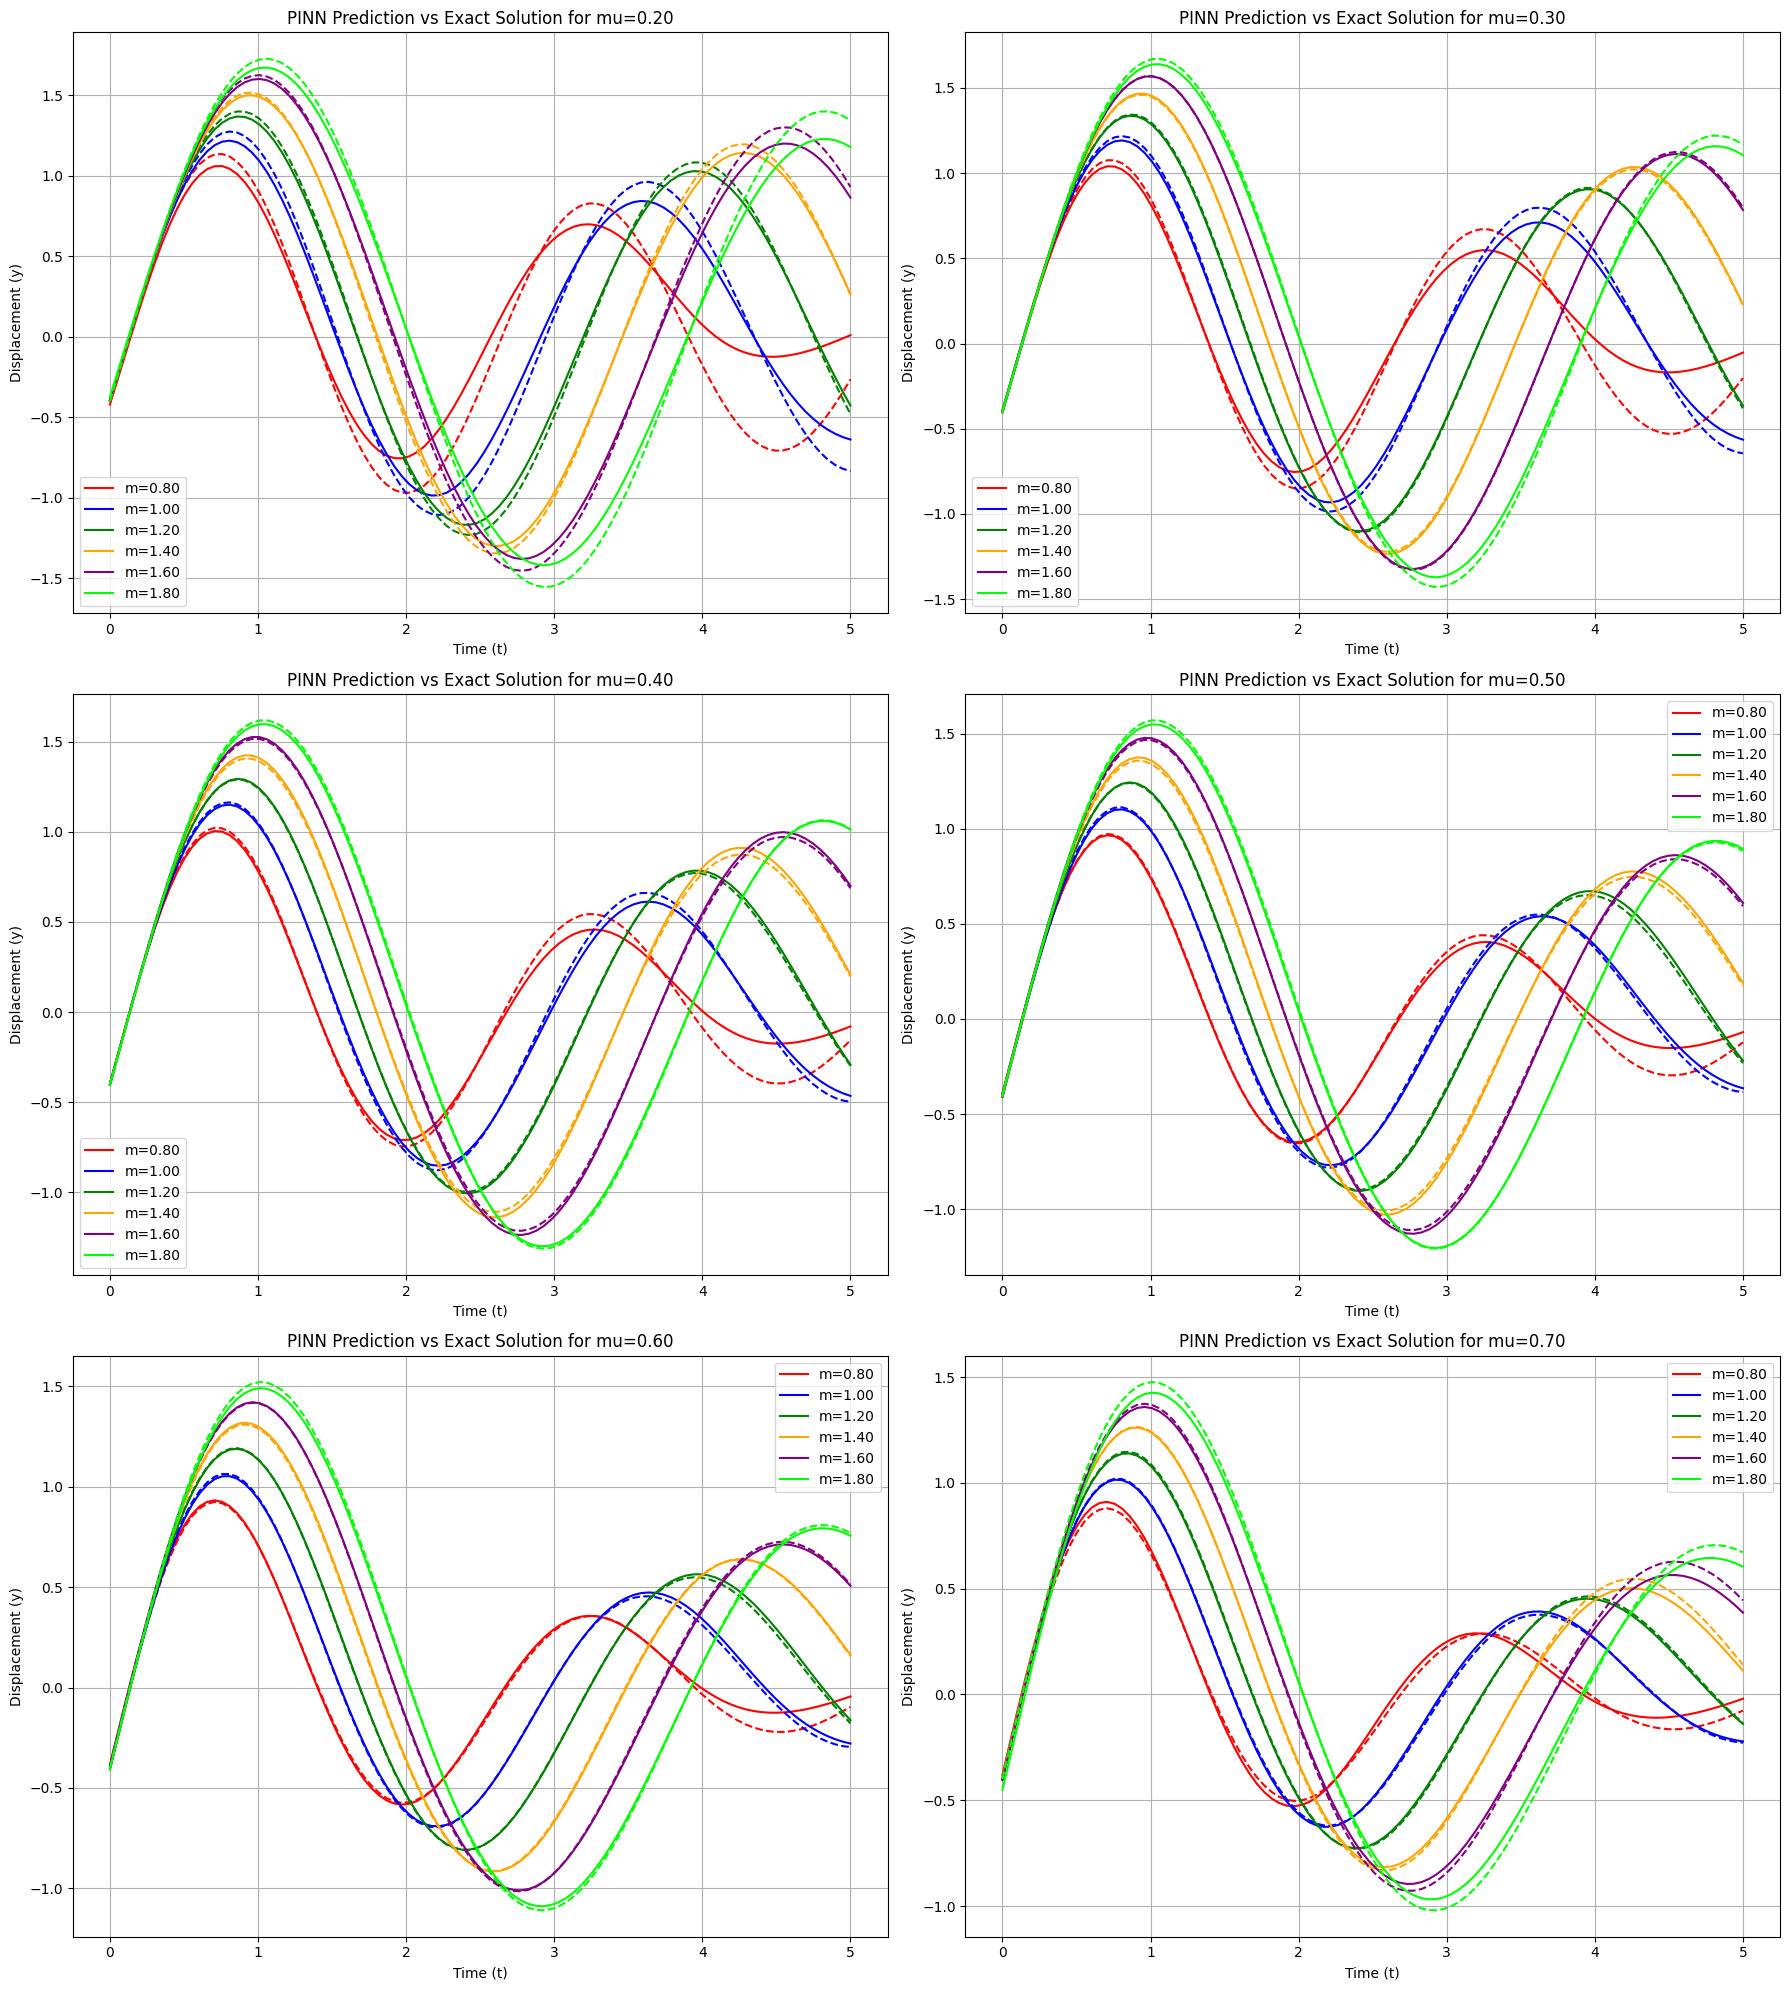

In [10]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'lime', 'brown', 'pink', 'gray', 'cyan']
m_values = np.linspace(m_mean + specs['m']['lower_multiplier'] * m_std, 
                       m_mean + specs['m']['upper_multiplier'] * m_std, 6)
mu_values = np.linspace(mu_mean + specs['mu']['lower_multiplier'] * mu_std, 
                        mu_mean + specs['mu']['upper_multiplier'] * mu_std, 6)
v0_values = np.linspace(v0_mean + specs['v0']['lower_multiplier'] * v0_std, 
                        v0_mean + specs['v0']['upper_multiplier'] * v0_std, 6)

fig, axes = plt.subplots(3, 2, figsize=(18, 20))
axes = axes.flatten()

for ax, mu in zip(axes,mu_values):

    for idx, m in enumerate(m_values):
        test_values = [m, mu, k_mean, y0_mean, v0_mean]
        test_params = make_input_params(t_coll, test_values, params['norm_info'])
        
        # Get the PINN prediction
        y_pred = PINN_model(t_coll, *test_params)
        # Compute the exact solution using the provided function (convert t_test to numpy)
        y_exact = damped_harmonic_oscillator(t_test, 
                                             *test_values)
        
        ax.plot(t_test, y_pred.detach().numpy(), color=colors[idx], label=f'm={m:.2f}')
        ax.plot(t_test, y_exact, color=colors[idx], linestyle='--')

    ax.set_title(f'PINN Prediction vs Exact Solution for mu={mu:.2f}')
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Displacement (y)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

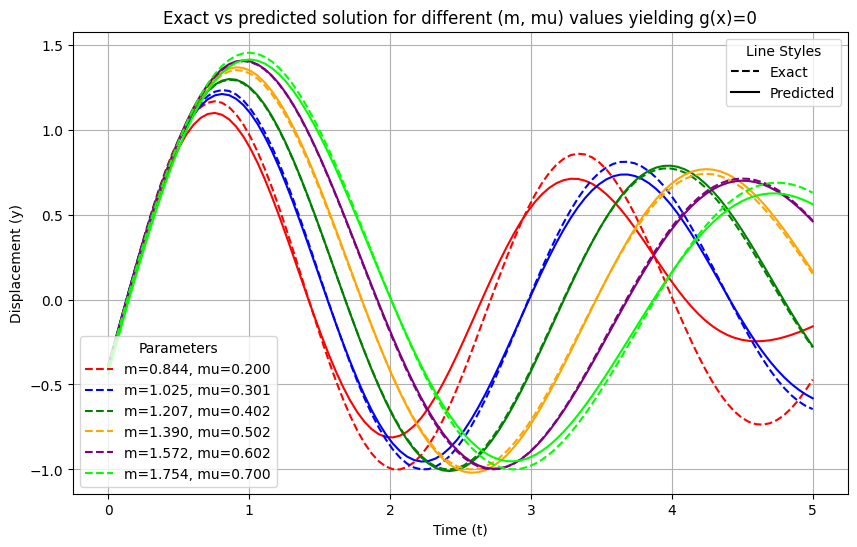


Combined Mean Squared Error over all 910 combinations: 0.002736


In [11]:
# g(x) = 0.0 for exact solution

from scipy.optimize import root_scalar

# Function to find mu for a given m where the exact solution is -1.0
def find_mu_g_equal_0(t,m,k, y0, v0, mu_bracket=(0.0, 2.0)):
    # Define the objective: we want the minimum of the solution to be -1
    def objective(mu):
        y_exact = damped_harmonic_oscillator(t, m=m, mu=mu, k=k, y0=y0, v0=v0)
        return np.min(y_exact) + 1.0  # When np.min(y_exact) == -1, this equals zero

    # Before starting, check that the bracket endpoints produce opposite signs
    a, b = mu_bracket
    if objective(a) * objective(b) > 0:
        raise ValueError("No sign change found in the objective function. Adjust mu_bracket values.")
    
    # Use the Brent's method (root_scalar with method='brentq') to find the root
    result = root_scalar(objective, bracket=mu_bracket, method='brentq')
    if result.converged:
        return result.root
    else:
        raise RuntimeError("Root finding did not converge.")

# Find mu values for each m
m_values = np.linspace(
    m_mean + specs['m']['lower_multiplier'] * m_std,
    m_mean + specs['m']['upper_multiplier'] * m_std,
    1000
)
mu_values = []

for m in m_values:
    mu_values.append(find_mu_g_equal_0(t_test, m, k_mean, y0_mean, v0_mean))

# Filter mu_values (and corresponding m_values) in one go:
filtered = [(m, mu) for m, mu in zip(m_values, mu_values)
            if specs['mu']['mean'] + specs['mu']['lower_multiplier'] * specs['mu']['std'] <= mu <= specs['mu']['mean'] + specs['mu']['upper_multiplier'] * specs['mu']['std']]

#Plott and compare the exact and predicted solutions for the filtered (m, mu) pairs
plt.figure(figsize=(10, 6))
idx=0
# Select five evenly distributed indices from the filtered list
selected_indices = np.linspace(0, len(filtered) - 1, 6, dtype=int)

for i in selected_indices:
    m, mu = filtered[i]
    color = colors[idx]  # Cycle through colors if idx exceeds length

    y_exact = damped_harmonic_oscillator(t_test, m=m, mu=mu, k=k_mean, y0=y0_mean, v0=v0_mean)

    pred_params = make_input_params(t_coll, [m, mu, k_mean, y0_mean, v0_mean], params['norm_info'])
    y_pred = PINN_model(t_coll, *pred_params)

    plt.plot(t_test, y_exact, label=f'm={m:.3f}, mu={mu:.3f}', linestyle='--', color=color)
    plt.plot(t_test, y_pred.detach().numpy(), color=color)

    idx += 1
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.title('Exact vs predicted solution for different (m, mu) values yielding g(x)=0')
plt.legend(loc='lower left')
plt.grid(True)

# Create dummy lines for the style legend
from matplotlib.lines import Line2D
line_exact = Line2D([0], [0], color='black', lw=1.5, linestyle='--')
line_pred = Line2D([0], [0], color='black', lw=1.5, linestyle='-')
# First legend for the (m, mu) labels
legend1 = plt.legend(loc='lower left', title='Parameters')
plt.gca().add_artist(legend1)
# Second legend for the line styles (exact vs predicted)
plt.legend([line_exact, line_pred], ['Exact', 'Predicted'], loc='upper right', title='Line Styles')

plt.show()

errors = []
for m,mu in filtered:
    y_exact = damped_harmonic_oscillator(t_test, m=m, mu=mu, k=k_mean, y0=y0_mean, v0=v0_mean)

    pred_params = make_input_params(t_coll, [m, mu, k_mean, y0_mean, v0_mean], params['norm_info'])
    y_pred = PINN_model(t_coll, *pred_params)

    mse = np.mean((y_pred.detach().numpy().flatten() - y_exact) ** 2)
    errors.append(mse)    
combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all {len(errors)} combinations: {combined_mse:.6f}")

### Probabilistic Algorithm

#### 3.

##### 3.1 sampling h_hat(u) with MCMC 

In [13]:
num_samples, num_initial_samples =1000, 10
accepted_samples, accepted_count = (metropolis_hastings(PINN_model,
                                    t_coll, 
                                    num_samples , 
                                    burn_in = 100, 
                                    num_initial_samples = num_initial_samples, 
                                    norm_info = params['norm_info'], 
                                    specs = specs, 
                                    sigma_hat_e = None,  #First round, it is None
                                    proposal_scale = 0.2)) 
#Uses u_prop[:, j] = np.random.normal(loc=u_curr[:, j], scale=proposal_scale*specs[param]['std'], size=u_curr.shape[0])
print(f"Accepeted samples: {accepted_count} out of {num_samples*num_initial_samples}")

Accepeted samples: 7620 out of 10000


##### 3.2

In [16]:
kmeans_centers = select_cluster_centers(accepted_samples, n_clusters=30, random_state=0)

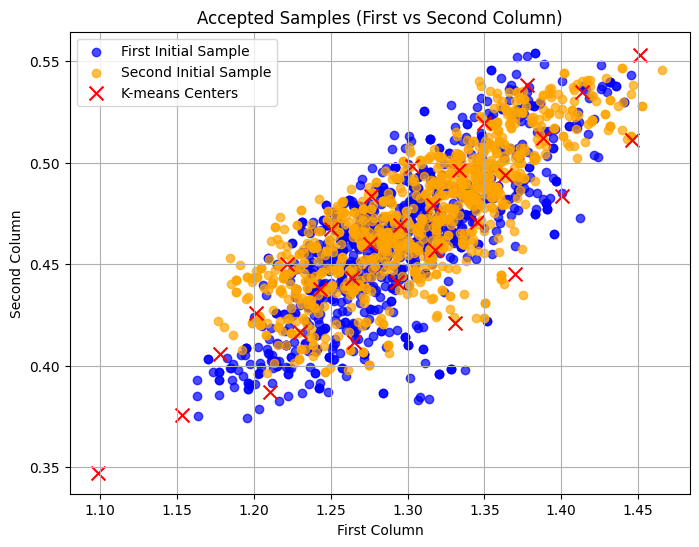

In [17]:
# Extract the first and second columns of accepted_samples
x_accepted = accepted_samples[:, :, 0]  # First column
y_accepted = accepted_samples[:, :, 1]  # Second column

# Create a scatter plot
plt.figure(figsize=(8, 6))

# Plot for the first initial sample
plt.scatter(x_accepted[:, 0], y_accepted[:, 0], color='blue', label='First Initial Sample', alpha=0.7)

# Plot for the second initial sample
plt.scatter(x_accepted[:, 1], y_accepted[:, 1], color='orange', label='Second Initial Sample', alpha=0.7)

# Plot for the k-means cluster centers
plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], color='red', label='K-means Centers', marker='x', s=100)

plt.title('Accepted Samples (First vs Second Column)')
plt.xlabel('First Column')
plt.ylabel('Second Column')
plt.legend()
plt.grid(True)
plt.show()

##### 3.3

In [26]:
g_kmean, y_exact_kmean = compare_g_exact_and_pred(PINN_model, t_coll, t_test, kmeans_centers, params['norm_info'])
print(g_kmean[:3])

[[ 0.04313263  0.02884841  0.01428422]
 [ 0.00669497 -0.01346982  0.02016479]
 [ 0.02849503  0.01930964  0.00918539]]


##### 3.4

In [27]:
#root mean square error
sigma_hat_e = np.sqrt(np.mean(g_kmean[:, 2]**2))
print(f"Root Mean Square Error: {sigma_hat_e:.6f}")

Root Mean Square Error: 0.016750


##### 3.5

In [29]:
pi_kmeans = norm.cdf(-g_kmean[:, 1]/sigma_hat_e)   # Should I use the true value or the predicted value?
# Indicator: 1 if true g <= 0, else 0
I_kmeans_exact = (g_kmean[:, 0] <= 0).astype(float)  # Exact indicator function

alpha_c_hat = np.mean(I_kmeans_exact/pi_kmeans)

print(f"Estimated alpha_c_hat: {alpha_c_hat:.6f}")

Estimated alpha_c_hat: 0.307695


##### 3.6

In [30]:
# variance of alpha_c_hat with updated values of pi
delta_alpha_squared  = 1 / (len(g_kmean) - 1) * (np.mean((I_kmeans_exact**2) / (pi_kmeans**2)) - alpha_c_hat**2)

print(f"Variance of alpha_c_hat: {delta_alpha_squared:.6f}")

Variance of alpha_c_hat: 0.007624


#### 4.

##### 4.1

In [36]:
num_samples = int(500/3.4e-4)
print(num_samples)

norm_samples, sampled_params = generate_normal_samples(specs, params['norm_info'], num_samples)

# 1. turn the NumPy array into a float32 Torch tensor
norm_samples_tensor = torch.from_numpy(norm_samples).float()

1470588


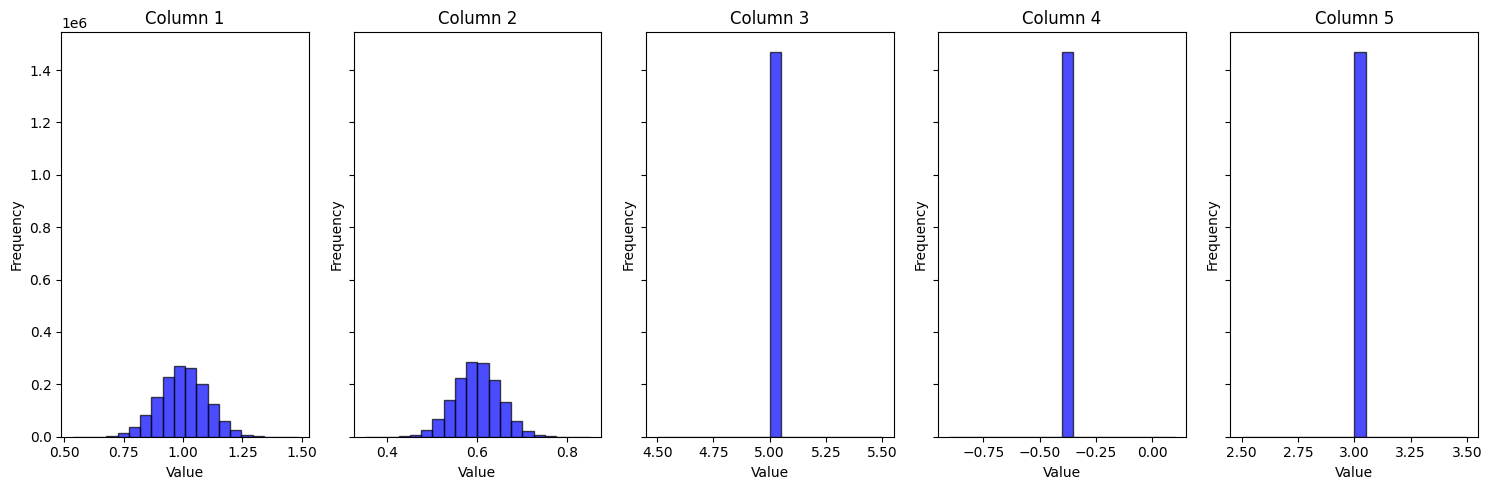

In [37]:
# Number of columns in norm_samples
num_columns = norm_samples.shape[1]

# Create subplots for each column
fig, axes = plt.subplots(1, num_columns, figsize=(15, 5), sharey=True)

for i in range(num_columns):
    axes[i].hist(norm_samples[:, i], bins=20, alpha=0.7, color='blue', edgecolor='black')
    axes[i].set_title(f'Column {i+1}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

##### 4.2

In [38]:
g_pred = evaluate_G_batchwise(
    PINN_model,
    norm_samples_tensor,
    t_coll,
    params['norm_info'],
    batch_size=64
)

In [39]:
print(g_pred.shape)
print(g_pred[:10])

num_below_zero = np.sum(g_pred < 0)
print(f"Number of values below 0 in g_pred: {num_below_zero}")

(1470588,)
[0.32249254 0.24551779 0.32366174 0.35376656 0.37110054 0.23524523
 0.35515225 0.3109299  0.3987074  0.29601586]
Number of values below 0 in g_pred: 49


##### 4.3

In [40]:
pi_values= norm.cdf(-g_pred/sigma_hat_e)

##### 4.4

In [46]:
P_hat_Fe = np.mean(pi_values)
print(f"Estimated probability of failure: {P_hat_Fe:.4e}")

Estimated probability of failure: 4.6361e-05


##### 4.5

In [45]:
#Variance of P_hat_Fe
delta_P_Fe_squared = 1 / (len(g_pred) - 1) * (np.mean((pi_values**2)) - P_hat_Fe**2)
print(f"Variance of P_hat_Fe: {delta_P_Fe_squared:.4e}")

Variance of P_hat_Fe: 1.7498e-11


#### 5.

In [43]:
# Total failure probability
P_F_hat = alpha_c_hat * P_hat_Fe
# Estimate the variance
delta_P_F_squared = delta_alpha_squared * delta_P_Fe_squared
# Coefficient of variation
CoV_P_F_hat = np.sqrt(delta_P_F_squared) / P_F_hat

print(f"Estimated total failure probability: {P_F_hat:.4e}")
print(f"Variance of total failure probability: {delta_P_F_squared:.4e}")
print(f"Coefficient of variation of total failure probability: {CoV_P_F_hat:.4e}")

Estimated total failure probability: 1.4265e-05
Variance of total failure probability: 1.3341e-13
Coefficient of variation of total failure probability: 2.5605e-02


#### 6.

In [47]:
# Check convergence- if not converged, continoue training the PINN model
if CoV_P_F_hat > 0.01:
    print("Convergence not achieved, continue training the PINN model.")
else:
    print("Convergence achieved, stop training the PINN model.")

Convergence not achieved, continue training the PINN model.


### Adaptive collocation point algorithm

In [48]:
data_loss_value = data_loss(PINN_model, kmeans_centers, y_exact_kmean, params['norm_info'], lambda_data=1.0)
print(f"Data loss value: {data_loss_value.item():.6f}")

Data loss value: 0.000233


In [94]:
N=100
t_coll = torch.linspace(0, 5, N).view(-1, 1) / specs['t']['range']
t_test = np.linspace(0, 5, N)

# Generate samples
num_samples = 10000

LHS_samples, sampled_params = generate_latin_hypercube_samples(specs, params['norm_info'], num_samples)
# 1. turn your (10000, 5) NumPy array into a float32 Torch tensor
samples_tensor = torch.from_numpy(LHS_samples).float()
# 3. call the function
G_vals,R_vals = evaluate_G_and_residual_batchwise(
    PINN_model,
    samples_tensor,
    t_coll,
    params['norm_info'],
    lambda_bc=2.0,
    batch_size=128
)
# print(LHS_samples)
# print(G_vals)
# print(R_vals)

print(LHS_samples[0])
print(np.min(damped_harmonic_oscillator(t_test,*LHS_samples[0]))+1.0)
print(G_vals[0])
print(R_vals[0])

[ 1.34003278  0.37077259  5.         -0.4         3.        ]
-0.10810434028563387
-0.12211609
0.00056066376


In [73]:
def sample_G_and_residual_points(G_vals, residual_vals, samples, alpha_g=20, alpha_residual=0.5, g_size=300, residual_size=200):
    # Sample near g(x) ≈ 0
    G_weights = np.exp(-alpha_g * np.abs(G_vals)) 
    G_weights /= np.sum(G_weights)  # Normalize weights
    G_indices = np.random.choice(len(samples), size=g_size, p=G_weights, replace=False)
    G_points_selected = samples[G_indices]

    # Sample near large residuals
    residual_weights = residual_vals**alpha_residual
    residual_weights /= np.sum(residual_weights)  # Normalize weights
    residual_indices = np.random.choice(len(samples), size=residual_size, p=residual_weights, replace=False)
    residual_points_selected = samples[residual_indices]
    # stack residual and G points
    points_selected = np.vstack((G_points_selected, residual_points_selected))
    return points_selected, G_points_selected, residual_points_selected

In [74]:
points_selected, G_points_selected, residual_points_selected = sample_G_and_residual_points(G_vals, R_vals, LHS_samples, alpha_g=20, alpha_residual=0.5, g_size=1000, residual_size=200)
print(points_selected[:10])

[[ 1.16436053  0.53149708  5.         -0.4         3.        ]
 [ 1.42798814  0.55634544  5.         -0.4         3.        ]
 [ 1.18495268  0.33598879  5.         -0.4         3.        ]
 [ 1.56006802  0.58113855  5.         -0.4         3.        ]
 [ 1.60481183  0.62074258  5.         -0.4         3.        ]
 [ 1.30724216  0.52446674  5.         -0.4         3.        ]
 [ 1.70069656  0.62850961  5.         -0.4         3.        ]
 [ 1.34949966  0.4882596   5.         -0.4         3.        ]
 [ 0.94528228  0.3019036   5.         -0.4         3.        ]
 [ 1.15646764  0.36706691  5.         -0.4         3.        ]]


Do I really need the residual here? I would have to try both, and see if adding high residual points actually helps. 

Also, I have not implemented a k_mean algorithm yet, since The points chosen looked quite wdespread already. Maybe I would need it if I use residual adaptive sampling with a high number for residul_vals**(Number). 

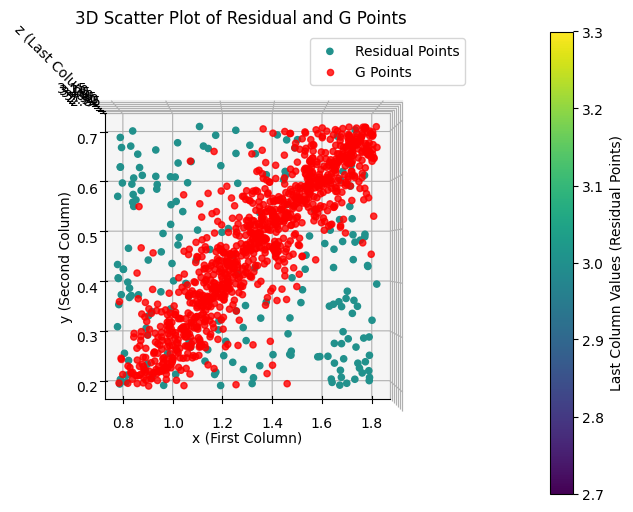

In [75]:
# Extract the first, second, and last columns of residual_points_selected for plotting
x_residual = residual_points_selected[:, 0]  # First column
y_residual = residual_points_selected[:, 1]  # Second column
z_residual = residual_points_selected[:, -1]  # Last column

# Extract the first, second, and last columns of G_points_selected for plotting
x_g = G_points_selected[:, 0]  # First column
y_g = G_points_selected[:, 1]  # Second column
z_g = G_points_selected[:, -1]  # Last column

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot residual_points_selected
scatter_residual = ax.scatter(x_residual, y_residual, z_residual, c=z_residual, cmap='viridis', label='Residual Points')

# Plot G_points_selected
scatter_g = ax.scatter(x_g, y_g, z_g, c='red', label='G Points', alpha=0.8)

# Add color bar for residual points
cbar = plt.colorbar(scatter_residual, ax=ax, pad=0.1)
cbar.set_label('Last Column Values (Residual Points)')

# Set labels and title
ax.set_title('3D Scatter Plot of Residual and G Points')
ax.set_xlabel('x (First Column)')
ax.set_ylabel('y (Second Column)')
ax.set_zlabel('z (Last Column)')

# Adjust the viewing angle
ax.view_init(elev=90, azim=-90)  # Change elevation and azimuth for a new angle

ax.legend()
plt.show()

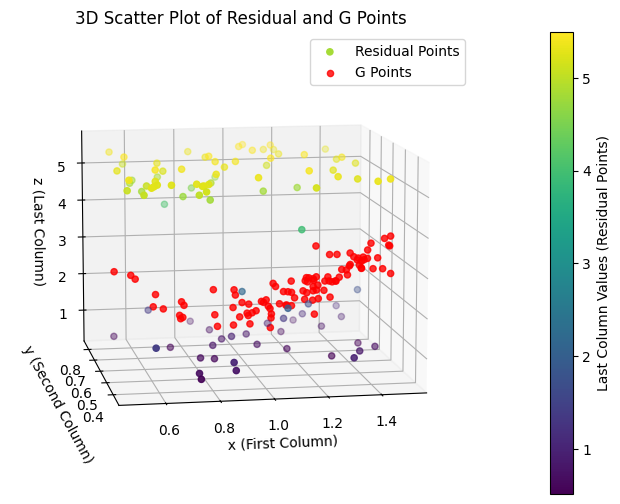
This piqture is good. It shows how it could be smart to narrow down the std search for paramter values. Here, sampling from v0 larger than 4 is not really necessary, since all the red points are below that. How do I implement that?

This adaptive refinement of paraeter space should be implemented, and this also goes for the physical space, and in my case time. No need to TRAIN THE pinn AFTER T=4 sek, but this is another impelemntation. 

Next training round 


In [76]:
print(params.keys())
print(params['t_coll'].shape)



new_params= make_new_params(points_selected, specs, params)
print(new_params['m'].shape)
print(new_params.keys())
print(new_params['norm_info'])

dict_keys(['t_coll', 'norm_info', 'm', 'mu', 'k', 'y0', 'v0', 't0'])
torch.Size([500, 1])
torch.Size([1200, 1])
dict_keys(['t_coll', 'norm_info', 'm', 'mu', 'k', 'y0', 'v0', 't0'])
{'t': {'range': 5.0}, 'm': {'mean': 1.0, 'std': 0.1}, 'mu': {'mean': 0.6, 'std': 0.05}}


Epoch 0, PDE loss: 0.001266904640942812, BC loss: 9.460905857849866e-06


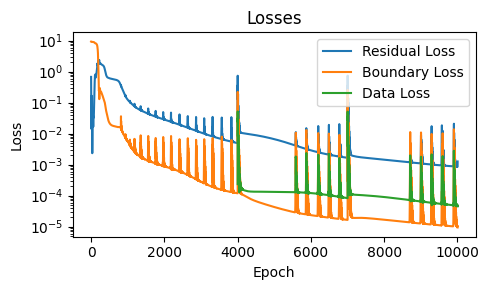

Epoch 1000, PDE loss: 0.0008935665246099234, BC loss: 7.81811831984669e-06


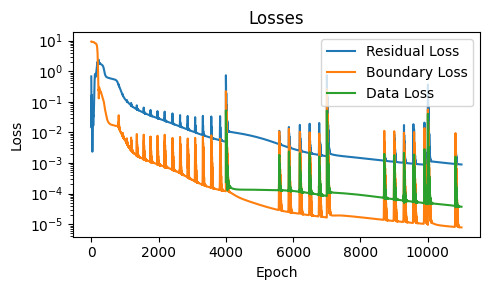

Epoch 2000, PDE loss: 0.0007423270726576447, BC loss: 6.609215233766008e-06


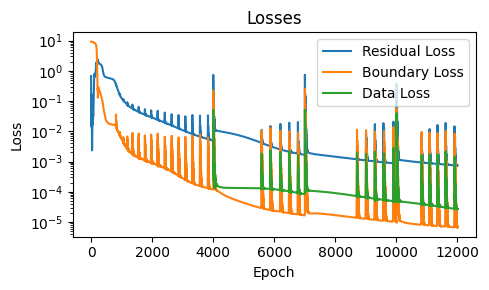

Epoch 3000, PDE loss: 0.000635240226984024, BC loss: 7.41885833122069e-06


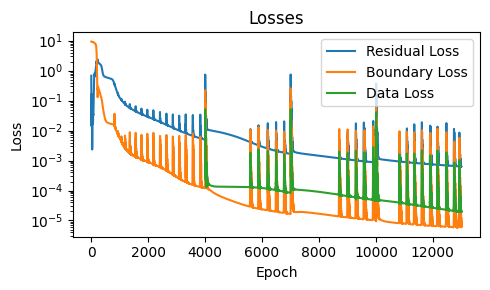

Phase 1 complete. Best loss so far: 0.0007136240601539612
Improved loss found: 0.0007120144437067211 (after 2 extra epochs)


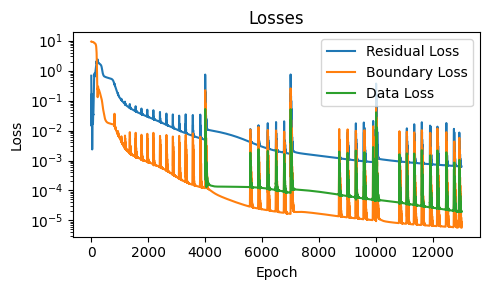

In [77]:
optimizer = optim.Adam(PINN_model.parameters(), lr=0.001)
trainer = Trainer(PINN_model, optimizer, epochs=3001, lambda_residual=1.0, lambda_bc=10.0, lambda_data=1.0, datapoints=kmeans_centers, y_exact_datapoints=y_exact_kmean)
trainer.train(new_params)

### Finding MPP with scipy.optimize minimize

In [ ]:
from scipy.optimize import minimize
def MPP_objective(x,model,t, values, lambda_penalty, norm_info):
    """
    Objective function: minimize |g(x)| while penalizing deviation from the input means.
    """
    all_values = list(x) + values
    pred_params = make_input_params(t, all_values, norm_info)
    lsf = limit_state_function_G(model, t, pred_params, differentiable=False)
    deviation=0
    for i,param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
        if param in norm_info:
            deviation+=(abs(x[i] - specs[param]['mean']) / specs[param]['std'])
    penalty = lambda_penalty * deviation

    return (abs(lsf) + penalty).item()
    
def find_MPP(model, t, values, norm_info, lamdba_penalty = 0.001):
    """
    Find the most probable point (MPP) using optimization.
    """
    MPP=[]
    x = []
    other_values = []
    for i,param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
        if param in norm_info:
            x.append(values[i])
        else:
            other_values.append(values[i])
    res = minimize(
        MPP_objective, 
        x, 
        args=(model, t, other_values, lamdba_penalty, norm_info), 
        method='Nelder-Mead'
        )
    if res.success:
        MPP.append(res.x)
    else:
        print(f"Start {i}: Optimization did not converge from initial guess {x}")
    return MPP

### Could also use jac and utlize autograd for the gradient
# def gradient(x, *args):
#     # must return a 1D array with same length as x
#     return ...


MPP_start = [m_mean, mu_mean, k_mean, y0_mean, v0_mean]

MPP = find_MPP(PINN_model, t_coll, MPP_start, params['norm_info'], lamdba_penalty=0.00001)
print(f"MPP: {MPP}")

#### Visualizing

In [ ]:
#Visualization of the MPP
mass_vals = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 100)
mu_vals = np.linspace(mu_mean - 8 * mu_std, mu_mean + 2 * mu_std, 100)
Mass, Mu = np.meshgrid(mass_vals, mu_vals)
Obj = np.zeros_like(Mass)

for i in range(Mass.shape[0]):
    for j in range(Mass.shape[1]):
        Obj[i, j] = MPP_objective([Mass[i, j], Mu[i, j]], PINN_model, t_coll, [k_mean, y0_mean, v0_mean],
                                        lambda_penalty=0.0, norm_info=params['norm_info'])

plt.figure(figsize=(8, 6))
cp = plt.contourf(Mass, Mu, Obj, levels=50, cmap='viridis')
plt.colorbar(cp)
# plt.scatter([pt[0] for pt in MPP[0]], [pt[1] for pt in MPP[0]],
#             color='red', label='MPP')
plt.scatter(MPP[0][0].item() , MPP[0][1].item(), color='lime', label='Scipy minimize MPP', edgecolor='black')
plt.scatter(m_mean, mu_mean, color='red', label='Mean', edgecolor='black')
plt.legend()
plt.title('Objective Function Contour Plot')
plt.xlabel('Mass (m)')
plt.ylabel('Damping Ratio (mu)')
plt.grid()
plt.show()

### MPP brute force

#### PINN_model

In [ ]:
def normal_pdf(x, mean, std):
    """Compute 1D normal PDF."""
    return 1.0/(std*np.sqrt(2*np.pi))*np.exp(-0.5*((x-mean)/std)**2)

num_points = 200  # Increase if you need a finer grid

m_vals = np.linspace(m_mean +2*m_std, m_mean + 4*m_std, num_points)
mu_vals = np.linspace(mu_mean - 4*mu_std, mu_mean -2*mu_std , num_points)

m_grid, mu_grid = np.meshgrid(m_vals, mu_vals)

# Time vector for evaluating the solution
n_t = 1000
t_grid = torch.linspace(0, 1, n_t).view(-1, 1)

best_m = None
best_mu = None
best_pdf = 0.0
best_g = None  # The g(m, mu) value at the MPP

# Tolerance for "on the boundary"
tol = 0.0001  # Adjust as needed for your "near 0" definition
# Evaluate g(m, mu) on grid
G = np.zeros((len(mu_vals), len(m_vals)))
for i,m in enumerate(m_vals):
    for j,mu in enumerate(mu_vals):
        test_values = [m_grid[j, i], mu_grid[j, i], k_mean, y0_mean, v0_mean]
        test_params = make_input_params(t_grid, test_values, params['norm_info'])
        g_val = limit_state_function_G(PINN_model,t_grid, test_params, differentiable=False).item()
        G[j, i] = np.nan if g_val is None else g_val
        
        # Check if we are near the failure boundary g=0
        if abs(g_val) < tol:  # "Close" to zero
            # Joint PDF
            f_m = normal_pdf(m, m_mean, m_std)
            f_mu = normal_pdf(mu, mu_mean, mu_std)
            joint_pdf = f_m * f_mu
            # If this is highest so far, record it
            if joint_pdf > best_pdf:
                best_pdf = joint_pdf
                best_m = test_values[0]
                best_mu = test_values[1]
                best_g = g_val

# Results
if best_m is None:
    print("No grid point near the failure boundary was found. Try increasing the range or tol.")
else:
    print(f"MPP found near boundary g(m,mu)=0 at:\n"
          f"  m  = {best_m:.6f}\n"
          f"  mu = {best_mu:.6f}\n"
          f"  g  = {best_g:.6f}   (should be close to 0)\n"
          f"  Joint PDF = {best_pdf:e}")


MPP found near boundary g(m,mu)=0 at:
  m  = 1.310553
  mu = 0.464322
  g  = 0.000044   (should be close to 0)
  Joint PDF = 6.451544e-03

#### Analytical function

In [ ]:
# Time vector for evaluating the solution
t_max = 5.0
n_t = 1000
t_grid = np.linspace(0, t_max, n_t)

best_m = None
best_mu = None
best_pdf = 0.0
best_g = None  # The g(m, mu) value at the MPP

# Tolerance for "on the boundary"
tol = 0.001  # Adjust as needed for your "near 0" definition
# Evaluate g(m, mu) on grid
G = np.zeros((len(mu_vals), len(m_vals)))
for i,m in enumerate(m_vals):
    for j,mu in enumerate(mu_vals):
        g_val = damped_harmonic_oscillator(t_grid, m=m, mu=mu, k=5.0, y0=-0.4, v0=3.0).min() +1
        G[j, i] = g_val
        
        # Check if we are near the failure boundary g=0
        if abs(g_val) < tol:  # "Close" to zero
            # Joint PDF
            f_m = normal_pdf(m, m_mean, m_std)
            f_mu = normal_pdf(mu, mu_mean, mu_std)
            joint_pdf = f_m * f_mu
            
            # If this is highest so far, record it
            if joint_pdf > best_pdf:
                best_pdf = joint_pdf
                best_m = m
                best_mu = mu
                best_g = g_val

# Results
if best_m is None:
    print("No grid point near the failure boundary was found. Try increasing the range or tol.")
else:
    print(f"MPP found near boundary g(m,mu)=0 at:\n"
          f"  m  = {best_m:.4f}\n"
          f"  mu = {best_mu:.4f}\n"
          f"  g  = {best_g:.6f}   (should be close to 0)\n"
          f"  Joint PDF = {best_pdf:e}")


MPP found near boundary g(m,mu)=0 at:
  m  = 1.3106
  mu = 0.4601
  g  = 0.000997   (should be close to 0)
  Joint PDF = 5.107185e-03

### FORM

In [ ]:
# Step 0: initialize u (standard normal variables)
u = torch.tensor([0.0] * (len(params['norm_info'])-1), dtype=torch.float32, requires_grad=True) # '-1' because 't' is also in norm_info

for i in range(100):
    # Step 1: __________________________________
    values = []
    for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
        if param in params['norm_info']:
            values.append(u[j])
        else:
            values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))

    t_FORM = torch.linspace(0, 1, 1000).view(-1, 1)
    input_params = tuple(v.expand(len(t_FORM), 1) for v in values)


    LSF= limit_state_function_G(PINN_model,t_FORM, input_params,differentiable=False)
    LSF.backward()

    # Extract gradient w.r.t. u
    grad_u = u.grad.detach().clone()  # ∇G/∇u
    norm_grad = torch.norm(grad_u)

    # Step 4: Compute update
    beta = LSF.item() / norm_grad.item()
    u_next = -beta * (grad_u / norm_grad)

    # Manually update u (we do it outside optimizer.step() to follow HL-RF logic)
    with torch.no_grad():
        u.copy_(u+u_next*0.2)
        # damping_factor = 0.6
        # u.copy_(u + damping_factor * (u_next - u))


    formatted_u_next = [f"{val:.4f}" for val in u_next.tolist()]
    formatted_u = [f"{val:.4f}" for val in u.tolist()]
    
    print(f'beta = {beta:.4f}')
    formatted_grad_u = [f"{val:.4f}" for val in grad_u.tolist()]
    print(f'grad_u = {formatted_grad_u}')
    print(f'norm_grad = {norm_grad:.4f}')
    print(f'LSF = {LSF.item()}')
    print(f'u_next = {formatted_u_next}')
    print(f'u = {formatted_u}')
    print('\n')
    u.grad.zero_()
    
print(f"∇G = {grad_u.tolist()}, ‖∇G‖ = {norm_grad:.4f}, β = {beta:.4f}")

beta = 0.0000
grad_u = ['-0.0565', '0.0496']
norm_grad = 0.0752
LSF = 0.0
u_next = ['0.0000', '-0.0000']
u = ['3.2879', '-2.5062']

In [ ]:
epsilon = 1e-3
finite_diff =[]
autograd_grad = []

start=-3
end=9
mu_test = 0

for i in np.linspace(start, end, 100):
    u_val = torch.tensor([i, mu_test], dtype=torch.float32, requires_grad=True)  # converged u, e.g. tensor([1.7616, -1.2246])
    fd_grad = torch.zeros_like(u_val)

    # Build a helper to compute G given a u vector:
    def compute_G(model, u_vector):
        values = []
        for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
            if param in params['norm_info']:
                # Using the same transformation as in your code
                values.append(u_vector[j])
            else:
                values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))
        input_params = tuple(v.expand(len(t_FORM), 1) for v in values)
        return limit_state_function_G(model,t_FORM, input_params, differentiable=True)

    LSF = compute_G(PINN_model,u_val)
    LSF.backward()
    grad_u = u_val.grad.detach().clone()

    for k in range(len(u_val)):
        u_plus = u_val.clone()
        u_minus = u_val.clone()
        u_plus[k] += epsilon
        u_minus[k] -= epsilon
        g_plus = compute_G(PINN_model,u_plus).item()
        g_minus = compute_G(PINN_model,u_minus).item()
        fd_grad[k] = (g_plus - g_minus) / (2 * epsilon)

    finite_diff.append(fd_grad.numpy())
    autograd_grad.append(grad_u.numpy())

# Extract the first element of each list in finite_diff
finite_diff_first_elements = [fd[0] for fd in finite_diff]
# Extract the first element of each list in autograd_grad
autograd_grad_first_elements = [ag[0] for ag in autograd_grad]

# Plot the first element of finite_diff against the linspace
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(start, end, 100), finite_diff_first_elements, label='Finite Difference (First Element)', color='blue')
plt.plot(np.linspace(start, end, 100), autograd_grad_first_elements, label='Autograd Gradient (First Element)', color='red', linestyle='--')
plt.xlabel('m')
plt.ylabel('Finite Difference (m)')
plt.title(f'dG/dm for mu = {mu_test} vs m')
plt.legend()
plt.grid()
plt.show()

finite_diff =[]
autograd_grad = []
norm_grad_list = []

start=-9
end=3
m_test = 0
for i in np.linspace(start, end, 100):
    u_val = torch.tensor([m_test, i], dtype=torch.float32, requires_grad=True)  # converged u, e.g. tensor([1.7616, -1.2246])
    fd_grad = torch.zeros_like(u_val)
    
    LSF = compute_G(PINN_model,u_val)
    LSF.backward()
    grad_u = u_val.grad.detach().clone()
    norm_grad = torch.norm(grad_u)
    norm_grad_list.append(norm_grad.item())
    for k in range(len(u_val)):
        u_plus = u_val.clone()
        u_minus = u_val.clone()
        u_plus[k] += epsilon
        u_minus[k] -= epsilon
        g_plus = compute_G(PINN_model,u_plus).item()
        g_minus = compute_G(PINN_model,u_minus).item()
        fd_grad[k] = (g_plus - g_minus) / (2 * epsilon)

    finite_diff.append(fd_grad.numpy())
    autograd_grad.append(grad_u.numpy())

finite_diff_second_elements = [fd[1] for fd in finite_diff]
autograd_grad_second_elements = [ag[1] for ag in autograd_grad]
print(norm_grad_list)
# Plot the second element of finite_diff against the linspace
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(start, end, 100), finite_diff_second_elements, label='Finite Difference (Second Element)', color='green')
plt.plot(np.linspace(start, end, 100), autograd_grad_second_elements, label='Autograd Gradient (Second Element)', color='orange', linestyle='--')
plt.xlabel('mu')
plt.ylabel('Finite Difference (mu)')
plt.title(f'dG/dmu for m = {m_test} vs mu')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# 1. Wrap u again to ensure it's a fresh, tracked variable
u_FORM = u.detach().clone().requires_grad_(True)

# 2. Rebuild `values` list using u_final
values = []
for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
    if param in params['norm_info']:
        values.append(u_FORM[j])  # Adjusted for the damping factor
    else:
        values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))

# 3. Expand to match t
input_params = tuple(v.expand(len(t_FORM), 1) for v in values)

# 4. Re-evaluate G
G_final = limit_state_function_G(PINN_model,t_FORM, input_params, differentiable=False)
print("Final G at converged u:", G_final)

In [ ]:
y_pred = PINN_model(t_FORM, *input_params)

plt.figure(figsize=(10, 6))
plt.plot(t_FORM, y_pred.detach().numpy(), label='PINN prediction')
# plt.plot(t_test.detach().numpy(), y_sol,label='Exact solution', linestyle='--')
plt.legend()
plt.title('PINN prediction')
plt.xlabel('t')
plt.ylabel('y')
plt.grid()
plt.show()

In [ ]:
########### MPP found ############
# Scypi minimize Model
m_mpp_model, mu_mpp_model = 1.25385061, 0.44097408
u1_mpp_model_scypi = (m_mpp_model - m_mean) / m_std
u2_mpp_model_scypi = (mu_mpp_model - mu_mean) / mu_std

# analytical brute force
m_mpp, mu_mpp = 1.3055,0.4573
u1_mpp = (m_mpp - m_mean) / m_std
u2_mpp = (mu_mpp - mu_mean) / mu_std

# Model brute force 
m_mpp_model, mu_mpp_model = 1.296482, 0.465829
u1_mpp_model = (m_mpp_model - m_mean) / m_std
u2_mpp_model = (mu_mpp_model - mu_mean) / mu_std

print(((u_FORM[0]**2 + u_FORM[1]**2)**0.5).item())
print((u1_mpp_model_scypi**2+u2_mpp_model_scypi**2)**0.5)
print((u1_mpp**2+u2_mpp**2)**0.5)
print((u1_mpp_model**2+u2_mpp_model**2)**0.5)

In [ ]:
Num=10000000
t_test = np.linspace(2, 3, 200)
# Uncertainty in input parameters
m_samples = np.random.normal(1, 0.1, Num)
mu_samples = np.random.normal(0.6, 0.05, Num)
count = 0 
for i in range(Num):
    # Generate random samples for m and mu
    m_sample = m_samples[i]
    mu_sample = mu_samples[i]
    
    g= damped_harmonic_oscillator(t_test, m_sample,mu_sample).min() + 1.0  # Exact solution for g(x) = 0
    if g<0:
        count+=1

print(count/Num)

### Plotting the MPPs

In [ ]:
# Convert u → physical space x
t_FORM = torch.linspace(0, 1, 1000).view(-1, 1)
t_test  = torch.linspace(0, 5, 1000).view(-1, 1)
physical_values = []
for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
    if param in params['norm_info']:
        physical_values.append(z_score_denormalize(u[j], params['norm_info'][param]))
    else:
        physical_values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))

# Define the grid for m and mu
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 100)
mu_values = np.linspace(mu_mean - 8 * mu_std, mu_mean +2 * mu_std, 100)
m_grid, mu_grid = np.meshgrid(m_values, mu_values)

# Evaluate the limit state function on the grid
g_values = np.zeros_like(m_grid)
g_values_exact = np.full(m_grid.shape, np.nan)


for i in range(m_grid.shape[0]):
    for j in range(m_grid.shape[1]):
        test_values = [m_grid[i, j], mu_grid[i, j], k_mean, y0_mean, v0_mean]
        test_params = make_input_params(t_FORM, test_values, params['norm_info'])
        g_values[i, j] = limit_state_function_G(PINN_model,t_FORM, test_params,differentiable=False).item()
        g_values_exact[i, j] = damped_harmonic_oscillator(t_test, *test_values).min() + 1.0  # Exact solution for g(x) = 0
        # Add a contour line at g = 0

# Create the contour plot
plt.figure(figsize=(10, 6))
contour = plt.contourf(m_grid, mu_grid, g_values, levels=20, cmap='viridis')
plt.contour(m_grid, mu_grid, g_values, levels=[0], colors='red', linestyles='--', linewidths=2)
plt.contour(m_grid, mu_grid, g_values_exact, levels=[0], colors='k', linewidths=1.5, linestyles='dashed')
plt.plot(params['norm_info']['m']['mean'], params['norm_info']['mu']['mean'], 'bo', label='Point mean')
plt.plot(physical_values[0].item(), physical_values[1].item(), 'ro', label='FORM point')
plt.plot(m_mpp, mu_mpp, 'o', color='lime', label='MPP analytical brute force')  
plt.legend()
plt.colorbar(contour, label='Limit State Function G')
plt.title('Contour Plot of Limit State Function G')
plt.xlabel('m')
plt.ylabel('mu')
plt.grid(True)
plt.show()

In [ ]:
# Define the grid for m and mu
m_values_norm = (m_values - m_mean) / m_std
mu_values_norm = (mu_values - mu_mean) / mu_std
m_grid, mu_grid = np.meshgrid(m_values_norm, mu_values_norm)

# Evaluate the limit state function on the grid
g_values = np.zeros_like(m_grid)

for i in range(m_grid.shape[0]):
    for j in range(m_grid.shape[1]):
        grid_values = []
        grid_values_physical = []
        for k, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
            u_grid=torch.tensor([m_grid[i, j], mu_grid[i, j]], dtype=torch.float32, requires_grad=True)  # converged u, e.g. tensor([1.7616, -1.2246])
            if param in params['norm_info']:
                grid_values.append(u_grid[k])
                grid_values_physical.append(z_score_denormalize(u_grid[k], params['norm_info'][param]).detach().numpy().item())
            else:
                grid_values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))
        # 3. Expand to match t
        input_params = tuple(v.expand(len(t_FORM), 1) for v in grid_values)
        g_values[i, j] = limit_state_function_G(PINN_model,t_FORM, input_params, differentiable=False).item()
        g_values_exact[i, j] = damped_harmonic_oscillator(t_test, *grid_values_physical).min() + 1.0
        # Add a contour line at g = 0

In [ ]:
# Create the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(m_grid, mu_grid, g_values, levels=50, cmap='viridis')
plt.contour(m_grid, mu_grid, g_values, levels=[0], colors='red', linestyles='--', linewidths=2)
plt.contour(m_grid, mu_grid, g_values_exact, levels=[0], colors='k', linewidths=1.5, linestyles='dashed')
# plt.plot(0, 0, 'ro', label='Point mean')
plt.plot(u[0].detach().numpy(),u[1].detach().numpy() , 'ro', label='FORM point')
plt.scatter(u1_mpp,u2_mpp, color='lime', edgecolor='black',  label='MPP analytical brute force')
plt.scatter(u1_mpp_model,u2_mpp_model, color='blue', edgecolor='black', label='MPP model brute force')
plt.scatter(u1_mpp_model_scypi,u2_mpp_model_scypi, color='orange', edgecolor='black', label='MPP scipy minimize')
plt.legend()
plt.colorbar(contour, label='Limit State Function G')
plt.title('Contour Plot of Limit State Function G')
plt.xlabel('m')
plt.ylabel('mu')
plt.grid()
plt.axis('equal')
plt.show()